Epoch 1/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8424 - val_loss: 0.4147 - learning_rate: 0.0010
Epoch 2/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4725 - val_loss: 0.3367 - learning_rate: 0.0010
Epoch 3/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3809 - val_loss: 0.2121 - learning_rate: 0.0010
Epoch 4/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2847 - val_loss: 0.1503 - learning_rate: 0.0010
Epoch 5/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2288 - val_loss: 0.1403 - learning_rate: 0.0010
Epoch 6/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2123 - val_loss: 0.1131 - learning_rate: 0.0010
Epoch 7/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2022 - val_loss: 0.1088 - learning_rate: 0.0010
Epoch 8/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1897 - val_loss: 0.0946 - learning_rate: 0.0010
Epoch 9/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1690 - val_loss: 0.1069 - learning_rate: 0.0010
E

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Проекты\\Дипломаня работа\\DoFitN\\Code\\DoFitN\\new_code\\Test\\game_models\\models\\autoencoder_loss.png'

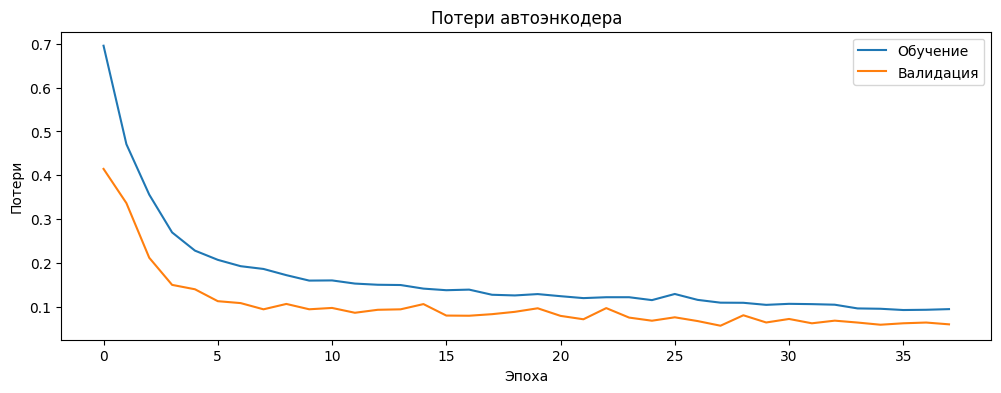

In [4]:
# Код для обучения автоэнкодера
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
def load_data(file_path):
    data = pd.read_csv(file_path)
    # Разделение на обычный и аномальный трафик
    normal = data[data['label'] == 0]
    attack = data[data['label'] == 1]
    return data, normal, attack

# Подготовка данных
def prepare_data(data):
    # Удаление ненужных столбцов и обработка категориальных признаков
    # Сначала копируем датафрейм, чтобы не изменять оригинал
    df = data.copy()
    
    # Определение категориальных признаков
    categorical_features = ['src_mac', 'dst_mac', 'src_ip', 'dst_ip']
    
    # Проверяем, есть ли эти колонки в данных
    cat_features_present = [col for col in categorical_features if col in df.columns]
    
    # Кодируем категориальные признаки
    for feature in cat_features_present:
        # Используем хеширование для уменьшения размерности
        df[f'{feature}_hash'] = df[feature].apply(lambda x: hash(str(x)) % 100)
        # Удаляем оригинальную колонку
        df = df.drop(feature, axis=1)
    
    # Проверяем наличие timestamp и session_id
    columns_to_drop = []
    if 'timestamp' in df.columns:
        columns_to_drop.append('timestamp')
    if 'session_id' in df.columns:
        columns_to_drop.append('session_id')
    
    # Удаление метки и неинформативных признаков
    X = df.drop(['label'] + columns_to_drop, axis=1) if columns_to_drop else df.drop('label', axis=1)
    y = df['label']
    
    # Замена inf и NaN значений
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(0)
    
    # Масштабирование данных
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, scaler

def create_autoencoder(input_dim):
    # Кодировщик с регуляризацией
    input_layer = Input(shape=(input_dim,))
    
    # Увеличиваем сложность сети
    encoded = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(input_layer)
    encoded = Dropout(0.3)(encoded)
    encoded = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(encoded)
    encoded = Dropout(0.3)(encoded)
    encoded = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(encoded)
    encoded = Dense(16, activation='relu')(encoded)
    
    # Декодировщик
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dropout(0.3)(decoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dropout(0.3)(decoded)
    decoded = Dense(128, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    
    # Создаем модель автоэнкодера
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    
    # Используем Adam с уменьшенной скоростью обучения
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    autoencoder.compile(optimizer=optimizer, loss='mse')
    
    return autoencoder

def train_autoencoder(autoencoder, X_train, X_test, epochs=100, batch_size=64):
    # Добавляем колбэки
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10,
        restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
    
    history = autoencoder.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, X_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    return history

# Оценка результатов
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score

def evaluate_autoencoder(autoencoder, X_test, y_test):
    # Получение реконструкции
    X_pred = autoencoder.predict(X_test)
    
    # Вычисление ошибки реконструкции
    mse = np.mean(np.power(X_test - X_pred, 2), axis=1)
    
    # Нахождение оптимального порога с помощью F1-меры
    precision, recall, thresholds = precision_recall_curve(y_test, mse)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    threshold = thresholds[optimal_idx] if len(thresholds) > optimal_idx else np.mean(mse)
    
    print(f"Оптимальный порог: {threshold:.6f} (F1: {f1_scores[optimal_idx]:.4f})")
    
    # Расчет ROC AUC
    fpr, tpr, _ = roc_curve(y_test, mse)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Предсказание на основе ошибки реконструкции
    y_pred = (mse > threshold).astype(int)
    
    # Оценка точности и F1
    accuracy = np.mean(y_pred == y_test)
    f1 = f1_score(y_test, y_pred)
    
    return mse, threshold, y_pred, accuracy, roc_auc, f1
# Визуализация результатов
# Визуализация результатов
# Визуализация результатов
def plot_results(history, mse, threshold, y_test):
    # Предсказание на основе ошибки реконструкции
    y_pred = (mse > threshold).astype(int)
    
    # График потерь
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Обучение')
    plt.plot(history.history['val_loss'], label='Валидация')
    plt.title('Потери автоэнкодера')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()
    plt.savefig('models/autoencoder_loss.png')
    
    # Распределение ошибок реконструкции
    plt.figure(figsize=(12, 6))
    normal_mse = mse[y_test == 0]
    attack_mse = mse[y_test == 1]
    
    plt.hist(normal_mse, bins=50, alpha=0.7, label='Нормальный трафик', color='skyblue')
    plt.hist(attack_mse, bins=50, alpha=0.7, label='Аномальный трафик', color='sandybrown')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Порог ({threshold:.4f})')
    plt.title('Распределение ошибок реконструкции автоэнкодера')
    plt.xlabel('Средняя квадратичная ошибка')
    plt.ylabel('Частота')
    plt.legend()
    plt.xlim(0, max(mse) + 1)  # Динамически устанавливаем предел оси X
    plt.savefig('models/autoencoder_reconstruction_error.png')
    
    # Матрица ошибок
    cm = tf.math.confusion_matrix(y_test, y_pred).numpy()
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Матрица ошибок: Автоэнкодер')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.savefig('models/autoencoder_confusion_matrix.png')
    
    # ROC кривая
    fpr, tpr, _ = roc_curve(y_test, mse)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC кривая (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая для автоэнкодера')
    plt.legend(loc="lower right")
    plt.savefig('models/autoencoder_roc_curve.png')

# Основная функция
def main():
    data, normal, attack = load_data(r'D:\Проекты\Дипломаня работа\DoFitN\Code\DoFitN\new_code\data_csv\combined_features.csv')
    X_train, X_test, y_train, y_test, scaler = prepare_data(data)
    
    autoencoder = create_autoencoder(X_train.shape[1])
    history = train_autoencoder(autoencoder, X_train, X_test)
    
    # Обновленный вызов с дополнительными возвращаемыми значениями
    mse, threshold, y_pred, accuracy, roc_auc, f1 = evaluate_autoencoder(autoencoder, X_test, y_test)
    print(f"Точность автоэнкодера: {accuracy:.4f}")
    print(f"F1-мера: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    plot_results(history, mse, threshold, y_test)
    
    # Создаем директорию для моделей, если она не существует
    import os
    os.makedirs('models', exist_ok=True)
    
    # Сохранение модели
    # Для новых версий TensorFlow/Keras нужно использовать расширение .keras
    try:
        autoencoder.save('models/autoencoder_model.keras')
        print("Модель сохранена в формате .keras")
    except:
        # Для старых версий можно использовать .h5
        autoencoder.save('models/autoencoder_model.h5') 
        print("Модель сохранена в формате .h5")
        
    # Сохраняем scaler для будущего использования
    from joblib import dump
    dump(scaler, 'models/scaler.joblib')

if __name__ == "__main__":
    main()

Нормальные данные: 5763 образцов
Аномальные данные: 5835 образцов
Размерность входных данных: 13


c:\Users\Slyexistence\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
289/289━━━━━━━━━━━━━━  252/289━━━━0s0s ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  254/289  2ms/step - loss: 0.6623━━━━━━━━━━━━━━━.7218━━━━━━━━━9148/289 2ms/step - loss: 0.728━━━━━━━━━━━━━━━━━  7/2892s0s  9ms/step - loss: 0.6759 2ms/step - loss: 0.7229  2ms/step - loss: 0.6998━━━━━━━━━━━━━━━━ ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6958   9/289  10ms/step - loss: 0.6774  8/289 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7178  11/289━━━━━━━━━━━━━━━━━━━━ 2s━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6769 9ms/step - loss: 0.6828   10ms/step - loss: 0.6798━━━━━━━━━━━━━━━━━━━ ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7542 2s 8ms/step - loss: 0.702    20/289━ 2s━━━━━━━━━━━━━━━━━━━━ 7ms/step - loss: 0.772 22/289   ━━━━━━━━━━━━━━━━━━2s━ 24/289 ━━ 8ms/step - loss: 0.7689  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1s ━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.77571s  7ms/step - loss: 0.78091s 7ms/step - loss: 0.77791s 6ms/step - loss: 0.7831 7ms/step - loss: 0.779 66/289

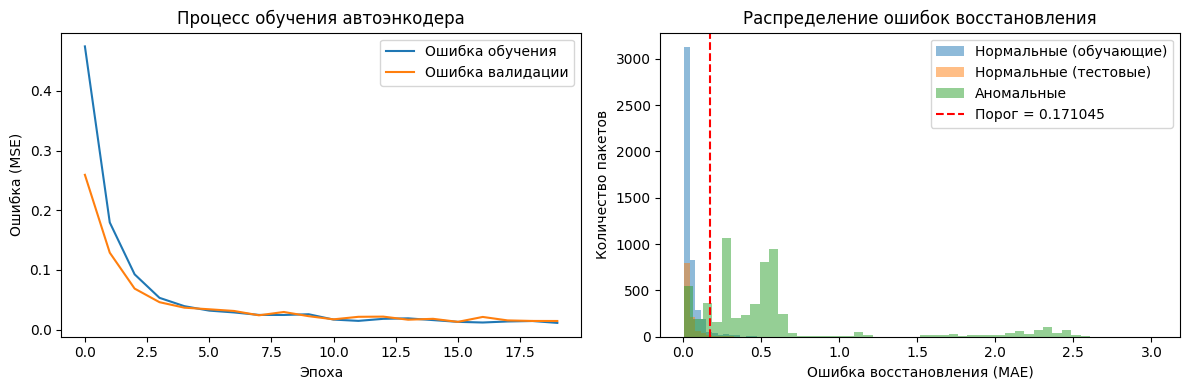

219/219ep━━━━━━━━━━━━━━━━━━━━   3/219 21ms/step  ━━━━━━━━━━━━━━━━━━━━  4/219 6ms/step ━━━━━━━━━━━━━━━━━━━━1s 0s 5ms/step 4ms/s 34/219━━ ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━0s 35/210s 36/219  2ms/step 2ms/step0s 2ms/step  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 0s 2ms/s 88 90/219━━━━━━━━━━━━━━━━━━━━━  92/2 93/219━━━━━━━━━━━━━━━━━━━━━━━━0s━━━━━━━━━━━━━━━━━━━━━━━ 1ms/step━━━━━━━━━━━━━━━━━━━━ 94/219━━━━━━━━━━━  ━━━━━━━━━━━━ 1ms/step0s 95/2190s0s 96/219━━━━━━━━ 1ms/step   1ms/step 1ms/step ━━━━━━━━━━━━ 1ms/step0s━━━━━━━━ 1ms/step━━━━━━━━━━━━━━━━━━━━  ━━━━━━━━━━━━0s0s 1ms/step 1ms/step 0s 2 156/158/219━━━━━━ ━━━━━━━━━━━━━━━━━━━━159/ ━━━━━━━━━━━━━━0s162/20s━━━━━━━━━━━━━━   1ms/step0s 163/219━━━━━━━━━━  1ms/step0s━━━━━━━━━━━━━━ 164/21━━━━━━0s 1ms/step━━━━━━0s0s━━━━━━━━━━━━━━ 165/219   1ms/step 1ms/step━━━━━━━━━━━━━━━━━━━━  1ms/step0s0s━━━━━━━━━━━━━━━ ━━━━━━ 1ms/step 1ms/step━━━━━0s  1ms/step 0s0s 1ms/step 1ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Метрики эффективности детектора:


Модель сохранена в файл 'arp_spoofing_detector.h5'


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Функция для преобразования MAC-адреса в число
def mac_to_int(mac):
    if isinstance(mac, str):
        try:
            return int(mac.replace(':', ''), 16)
        except:
            return 0
    return 0

# Функция для преобразования IP-адреса в число
def ip_to_int(ip):
    if isinstance(ip, str):
        try:
            parts = ip.split('.')
            return int(parts[0]) * 16777216 + int(parts[1]) * 65536 + int(parts[2]) * 256 + int(parts[3])
        except:
            return 0
    return 0

# Загрузка и предобработка данных
def load_and_preprocess_data(csv_file):
    # Загружаем данные
    df = pd.read_csv(csv_file)
    
    # Преобразуем MAC-адреса в числовые признаки
    df['src_mac_num'] = df['src_mac'].apply(mac_to_int)
    df['dst_mac_num'] = df['dst_mac'].apply(mac_to_int)
    
    # Преобразуем IP-адреса в числовые признаки
    df['src_ip_num'] = df['src_ip'].apply(ip_to_int)
    df['dst_ip_num'] = df['dst_ip'].apply(ip_to_int)
    
    # Преобразуем строковые булевы значения в числовые
    if 'is_broadcast' in df.columns and df['is_broadcast'].dtype == 'object':
        df['is_broadcast'] = df['is_broadcast'].map({'True': 1, 'False': 0})
    
    # Обработка бесконечных значений
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Заполняем отсутствующие значения
    df = df.fillna(0)
    
    # Выбираем числовые признаки для модели (исключаем строковые и метки)
    features = df[['timestamp', 'src_mac_num', 'dst_mac_num', 'src_ip_num', 'dst_ip_num',
                  'opcode', 'is_broadcast', 'duplicates', 'requests', 'replies',
                  'packet_rate', 'multiple_macs', 'request_reply_ratio']]
    
    # Сохраняем метки для оценки модели
    labels = df['label'] if 'label' in df.columns else None
    
    return features.values, labels.values if labels is not None else None

# Загрузка данных из объединенного файла
combined_file = r"D:\Проекты\Дипломаня работа\DoFitN\Code\DoFitN\new_code\data_csv\combined_features.csv"
all_features, all_labels = load_and_preprocess_data(combined_file)

# Разделяем данные на нормальные и аномальные
normal_idx = (all_labels == 0)
anomaly_idx = (all_labels == 1)

normal_data = all_features[normal_idx]
anomaly_data = all_features[anomaly_idx]

print(f"Нормальные данные: {normal_data.shape[0]} образцов")
print(f"Аномальные данные: {anomaly_data.shape[0]} образцов")

# Разделяем нормальные данные на обучающую и тестовую выборки
X_train, X_test = train_test_split(normal_data, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
anomaly_data_scaled = scaler.transform(anomaly_data)

# Создание автоэнкодера
input_dim = X_train_scaled.shape[1]
print(f"Размерность входных данных: {input_dim}")

encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu')
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

autoencoder = tf.keras.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')

# Обучение автоэнкодера
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=20,
    batch_size=16,
    validation_data=(X_test_scaled, X_test_scaled),
    verbose=1
)

# Графики процесса обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Ошибка обучения')
plt.plot(history.history['val_loss'], label='Ошибка валидации')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка (MSE)')
plt.legend()
plt.title('Процесс обучения автоэнкодера')

# Определение порога аномалий
reconstructions = autoencoder.predict(X_train_scaled)
train_loss = tf.keras.losses.mae(reconstructions, X_train_scaled).numpy()
threshold = np.mean(train_loss) + 2 * np.std(train_loss)

# Расчет ошибок реконструкции для тестовых и аномальных данных
test_reconstructions = autoencoder.predict(X_test_scaled)
test_loss = tf.keras.losses.mae(test_reconstructions, X_test_scaled).numpy()

anomaly_reconstructions = autoencoder.predict(anomaly_data_scaled)
anomaly_loss = tf.keras.losses.mae(anomaly_reconstructions, anomaly_data_scaled).numpy()

# Функция детекции аномалий
def detect_anomalies(data_scaled):
    reconstructions = autoencoder.predict(data_scaled)
    loss = tf.keras.losses.mae(reconstructions, data_scaled).numpy()
    return loss > threshold

# Применяем детектор
normal_anomalies = detect_anomalies(X_test_scaled)
attack_anomalies = detect_anomalies(anomaly_data_scaled)

# Оценка результатов
print(f"Порог аномалий: {threshold:.6f}")
print(f"Процент ложных срабатываний в нормальных данных: {100 * np.mean(normal_anomalies):.2f}%")
print(f"Процент обнаружения аномалий: {100 * np.mean(attack_anomalies):.2f}%")

# Визуализация результатов
plt.subplot(1, 2, 2)
plt.hist(train_loss, bins=50, alpha=0.5, label='Нормальные (обучающие)')
plt.hist(test_loss, bins=50, alpha=0.5, label='Нормальные (тестовые)')
plt.hist(anomaly_loss, bins=50, alpha=0.5, label='Аномальные')
plt.axvline(threshold, color='r', linestyle='--', label=f'Порог = {threshold:.6f}')
plt.legend()
plt.title('Распределение ошибок восстановления')
plt.xlabel('Ошибка восстановления (MAE)')
plt.ylabel('Количество пакетов')

plt.tight_layout()
plt.show()

# Оценка эффективности детектора
normal_labels = np.zeros(len(X_test_scaled))
anomaly_labels = np.ones(len(anomaly_data_scaled))

all_data = np.vstack([X_test_scaled, anomaly_data_scaled])
all_preds = detect_anomalies(all_data)
all_labels = np.hstack([normal_labels, anomaly_labels])

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print("\nМетрики эффективности детектора:")
print(f"Точность (Accuracy): {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nМатрица ошибок:")
print(conf_matrix)

# Сохранение модели
autoencoder.save("arp_spoofing_detector.h5")
print("\nМодель сохранена в файл 'arp_spoofing_detector.keras'")